Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 396/396 [00:26<00:00, 14.96it/s]
c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\model1_class.py:316: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%'])
c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\model2_class.py:253: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%'])


This is the wealth groups data [[0.26010450474239133, 0.2596726134883355, 0.260927203725077, 0.2606169574532614, 0.2615612661846753, 0.26137305265672683, 0.26106188989692625, 0.2605869185986455, 0.26103794458211493, 0.26212528007614755, 0.263292604523739, 0.26277193572253943, 0.26227289322986475, 0.26177487656996923, 0.2623467967085462, 0.2618691841531686, 0.2618653418543616, 0.26237540797032993, 0.2629872056966424, 0.2639266421408696, 0.26439135900238714, 0.2642384399711182, 0.26379805099126463, 0.264941380866845, 0.26521900764338685, 0.2647354909652773, 0.2646435325976185, 0.2642023109085249, 0.26396755640226216, 0.2651105378421674, 0.2659839414984636, 0.26590997283397105, 0.2663089446948328, 0.26658376030434344, 0.2664057785477666, 0.266474834898795, 0.26605040480156894, 0.2661201916596034, 0.26662151149752095, 0.2662584479535602, 0.2670061558394924, 0.2673823183636414, 0.2674699233580679, 0.26761901633347146, 0.2671100101718783, 0.2669515026756481, 0.26675220896643176, 0.2664916568

C:\Users\yoswald\AppData\Local\Temp\ipykernel_34752\3989627955.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\yoswald\AppData\Local\Temp\ipykernel_34752\3989627955.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\yoswald\AppData\Local\Temp\ipykernel_34752\3989627955.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\yoswald\AppData\Local\Temp\ipykernel_34752\3989627955.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fix

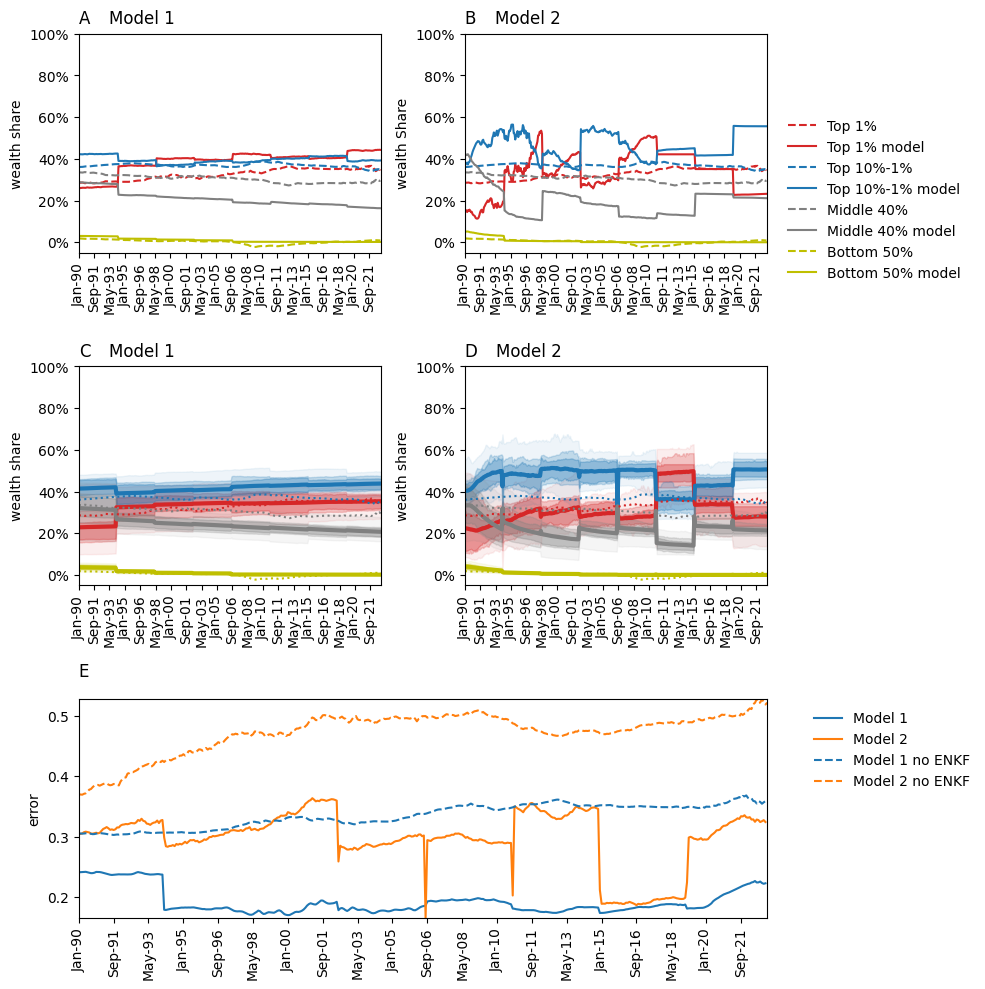

In [1]:
#General packages
import os
import numpy as np
from tqdm import tqdm  ### package for progress bars
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
### MODEL 1 infrastructure
import pandas as pd
from model1_class import Model1
from run_enkf import *
### MODEL 2 infrastructure
from model2_class import Model2
#from run_both_models_n_times_and_compute_error import *
import import_ipynb
import matplotlib.ticker as mtick
tqdm.pandas()

#%%


class Experiment1:
    def __init__(self, num_agents, ensemble_size, macro_state_dim, start_year, end_year, filter_freq):
        self.num_agents = num_agents
        self.ensemble_size = ensemble_size
        self.macro_state_dim = macro_state_dim
        self.enkf1 = None
        self.enkf2 = None
        self.start_year = start_year
        self.end_year = end_year

    def run_both_enkf(self, filter_freq):
        
        model_params1 = {"population_size": self.num_agents,
                        "growth_rate": 0.025,
                        "b_begin": 1.3,
                        "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                        "start_year": self.start_year,
                        "uncertainty_para": 0.1}
        
        model_params2 = {"population_size": self.num_agents, 
                        "concavity": 1,
                        "growth_rate": 0.025,
                        "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                        "start_year": self.start_year,
                        "adaptive_sensitivity": 0.02,
                        "uncertainty_para": 0}

        
        self.enkf1 = prepare_enkf(Model1,
                                  model_params= model_params1,
                                  ensemble_size = self.ensemble_size,
                                  macro_state_dim = self.macro_state_dim,
                                  filter_freq = filter_freq,
                                  uncertainty_obs = 0.5)
        
        self.enkf2 = prepare_enkf(Model2,
                                   model_params= model_params2,
                                  ensemble_size = self.ensemble_size,
                                  macro_state_dim = self.macro_state_dim,
                                  filter_freq = filter_freq,
                                  uncertainty_obs = 0.5)
        
        run_enkf(self.enkf1, start_year=self.start_year, end_year=self.end_year, filter_freq = filter_freq)
        run_enkf(self.enkf2, start_year=self.start_year, end_year=self.end_year, filter_freq = filter_freq)

    def plot_results(self):

        fig = plt.figure(figsize=(10, 10))
        # Create a gridspec object
        gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
        # Create individual subplots
        ax0 = plt.subplot(gs[0, 0])
        ax1 = plt.subplot(gs[0, 1])
        ax2 = plt.subplot(gs[1, 0])
        ax3 = plt.subplot(gs[1, 1])
        #ax4 = plt.subplot(gs[2, 0])
        #ax5 = plt.subplot(gs[2, 1])
        ax4 = plt.subplot(gs[2, :])  # This one spans both columns

        self.enkf1.models[0].plot_wealth_groups_over_time(ax0, self.start_year, self.end_year)
        self.enkf2.models[0].plot_wealth_groups_over_time(ax1, self.start_year, self.end_year)

        #self.enkf1.models[1].plot_wealth_groups_over_time(ax2, self.start_year, self.end_year)
        #self.enkf2.models[1].plot_wealth_groups_over_time(ax3, self.start_year, self.end_year)

        self.enkf1.plot_fanchart(ax2)
        self.enkf2.plot_fanchart(ax3)        
        self.enkf1.plot_error(ax4)
        self.enkf2.plot_error(ax4)

        ###EXTRAS
        #AX0
        ax0.text(0, 1.05, 'A', fontsize = 12)
        ax0.text(40, 1.05, 'Model 1', fontsize = 12)
        ax0.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%', '100%'])
        #AX1
        ax1.legend(loc=(1.05, -0.15), frameon = False) ### legend only here
        ax1.text(0, 1.05, 'B', fontsize = 12)
        ax1.text(40, 1.05, 'Model 2', fontsize = 12)
        ax1.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%', '100%'])
        #AX2
        ax2.text(0, 1.05, 'C', fontsize = 12)
        ax2.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%', '100%'])
        ax2.text(40,1.05, 'Model 1', fontsize = 12)
        #AX3
        ax3.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%', '100%'])
        ax3.text(0,1.05, 'D', fontsize = 12)
        ax3.text(40,1.05, 'Model 2', fontsize = 12)

        path = '..'
        with open(os.path.join(path, 'data', 'mean_errors.csv')) as f:
            errors_df_no_enkf = pd.read_csv(f, encoding='unicode_escape')

        ax4.plot(errors_df_no_enkf['mean_error_model1'], linestyle='--', label='Model 1 no ENKF', color='tab:blue')
        ax4.plot(errors_df_no_enkf['mean_error_model2'], linestyle='--', label='Model 2 no ENKF', color='tab:orange')
        ax4.legend(bbox_to_anchor=(1.05, 1), frameon=False)
        
        # Get the limits
        x_min, x_max = ax4.get_xlim()
        y_min, y_max = ax4.get_ylim()
        ax4.text(0, y_max+0.02, 'E', fontsize = 12)
        ax4.margins(0)


        plt.tight_layout()
        plt.savefig('fig4.png', dpi=300)
        plt.show()
         
        
# Example usage
if __name__ == "__main__":
    filter_freq = 50
    experiment1 = Experiment1(num_agents=100, 
                              ensemble_size=30, 
                              macro_state_dim=4, # needs to be set to 3 for the model to work if num_agents < 100
                              start_year=1990, #min start year is 1972
                              end_year=2022,# max end year is 2022
                              filter_freq = filter_freq)
    experiment1.run_both_enkf(filter_freq = filter_freq)
    experiment1.plot_results()
    agent_states_model1 = experiment1.enkf1.micro_history
    agent_states_model2 = experiment1.enkf2.micro_history


## Analysis of numerical instability and filter behaviour during update step

        agent_id_1  agent_id_2  time_step        amount
14714            4           7        213  1.847140e+06
155801           4           7        213  1.847140e+06
14715            4           7        213  1.847140e+06
330077           3           3         82  1.724057e+06
330079           3           3         82  1.724057e+06
...            ...         ...        ...           ...
526926          37          30        365  6.279201e-17
526927          37          30        365  6.279201e-17
519459          75          28        307  5.979354e-17
423568          75          28        307  5.979354e-17
519460          75          28        307  5.979354e-17

[691416 rows x 4 columns]
this is shape error per time step ()
this is micro state vector [[2.22688231e+04 0.00000000e+00]
 [1.58641049e+05 1.00000000e+00]
 [7.85657269e+05 2.00000000e+00]
 [5.69735509e+05 3.00000000e+00]
 [1.50594878e+05 4.00000000e+00]
 [3.21013022e+05 5.00000000e+00]
 [1.58233050e+05 6.00000000e+00]
 [1.51

"\ndata_ensemble_historyMODEL1 = experiment1.enkf1.data_ensemble_history\nstate_ensemble_historyMODEL1= experiment1.enkf1.state_ensemble_history\t\nH = experiment1.enkf1.H\nKalman_Gain_historyMODEL1 = experiment1.enkf1.Kalman_Gain_history \ndiff_historyMODEL1  = experiment1.enkf1.diff_history\nprint(data_ensemble_historyMODEL1[update_step_choice].shape)\nprint(state_ensemble_historyMODEL1[update_step_choice].shape)\nprint(H.shape)\nprint(Kalman_Gain_historyMODEL1[update_step_choice].shape)\n\n\n# print first element data ensemble and state ensemble and Kalman Gain\nprint('this data ensemble history model 1', data_ensemble_historyMODEL1[update_step_choice])\nprint('this is state ensemble history model 1', state_ensemble_historyMODEL1[update_step_choice])\nprint('this is Kalman Gain history model 1', Kalman_Gain_historyMODEL1[update_step_choice])\nprint('this is diff history model 1', diff_historyMODEL1[update_step_choice])\n\n# analyse variance of data ensemble\nvariance_data_ensemble =

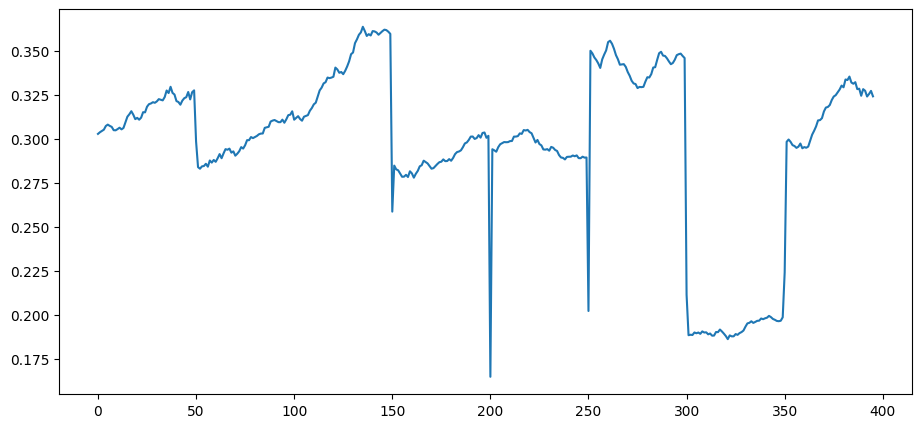

In [2]:
test = experiment1.enkf2.models[0].macro_state_vectors
test2 = experiment1.enkf2.models[0].micro_state_vectors


transactions_one_agent = experiment1.enkf2.models[0].agents[0].transaction_history

# Initialize an empty list to store all transaction data of all agents
transaction_data = []

# Loop over all agents and append their transaction history to transaction_data
for agent in experiment1.enkf2.models[0].agents:
    # Create a DataFrame for the current agent's transaction history
    df = pd.DataFrame(agent.transaction_history, columns=['agent_id_1', 'agent_id_2', 'time_step', 'amount'])
    # Append the DataFrame to the transaction_data list
    transaction_data.append(df)

# Concatenate all DataFrames in the transaction_data list into a single DataFrame
final_df = pd.concat(transaction_data, ignore_index=True)

# Sort the final DataFrame by the 'amount' column in descending order
final_df = final_df.sort_values(by='amount', ascending=False)

# Save the final DataFrame as a CSV file
final_df.to_csv('transaction_data.csv', index=False)

# Display the final DataFrame
print(final_df)

test3 = experiment1.enkf2.macro_history_share
test4 = experiment1.enkf2.macro_history
test4 = [[ensemble[1:] for ensemble in wealth_group] for wealth_group in test4]


test5 = experiment1.enkf2.macro_state_ensemble_history

test6 = np.mean(np.array(experiment1.enkf2.error_history),axis = 1)

plt.plot(test6)

print('this is shape error per time step' , test6[0].shape)

# Initialize an empty list to store data for the DataFrame
data = []

# Iterate over wealth groups and their respective ensemble members
for wealth_group_idx, (wealth_group_share, wealth_group_abs) in enumerate(zip(test3, test4)):
    for ensemble_idx, (ensemble_share, ensemble_abs) in enumerate(zip(wealth_group_share, wealth_group_abs)):
        for time_step_idx, (value_share, value_abs) in enumerate(zip(ensemble_share, ensemble_abs)):
            data.append([wealth_group_idx + 1, ensemble_idx + 1, time_step_idx + 1, value_share, value_abs])

# Create DataFrame
df = pd.DataFrame(data, columns=['Wealth Group', 'Ensemble Member', 'Time Step', 'Value', 'Abs_Value'])

# Save DataFrame to CSV
df.to_csv('output_enkf2.csv', index=False)



# Initialize an empty list to store the data
data = []

# Iterate over the time steps
for time_step in range(len(experiment1.enkf2.models[0].micro_state_vectors)):
    # Extract the micro state vector for the current time step
    micro_state_vector = experiment1.enkf2.models[0].micro_state_vectors[time_step]
    print('this is micro state vector', micro_state_vector)
    # Iterate over each element in the micro state vector
    for agent_id, element in enumerate(micro_state_vector):
        # Extract the scalar value from the array
        scalar_element = element[0] if isinstance(element, (list, np.ndarray)) else element
        agent_id = element[1] if isinstance(element, (list, np.ndarray)) else agent_id
        data.append([time_step + 1, agent_id, scalar_element])

# Create a DataFrame from the data list
df = pd.DataFrame(data, columns=['Time Step', 'Agent ID', 'Micro State Element'])

# Save the DataFrame to a CSV file
df.to_csv('micro_state_vectors_model2.csv', index=False)
'''
update_step_choice = 0

# MODEL 2 ENKF analysis
# get data ensemble, state ensemble, H, Kalman Gain

data_ensemble_history = experiment1.enkf2.data_ensemble_history
state_ensemble_history = experiment1.enkf2.state_ensemble_history	
H = experiment1.enkf2.H
Kalman_Gain_history = experiment1.enkf2.Kalman_Gain_history 
diff_history  = experiment1.enkf2.diff_history 
print(data_ensemble_history[update_step_choice].shape)
print(state_ensemble_history[update_step_choice].shape)
print(H.shape)
print(Kalman_Gain_history[update_step_choice].shape)
print(diff_history[update_step_choice].shape)

# print first element data ensemble and state ensemble and Kalman Gain
print('this data ensemble history model 2', data_ensemble_history[update_step_choice])
print('this is state ensemble history model 2', state_ensemble_history[update_step_choice])
print('this is Kalman Gain history model 2', Kalman_Gain_history[update_step_choice])
print('this is diff history model 2', diff_history[update_step_choice])

# analyse variance of data ensemble
variance_data_ensemble = np.var(data_ensemble_history[update_step_choice], axis = 1)
print('this is variance of data ensemble model 2', variance_data_ensemble)
'''

agent_state_history_model_2 = experiment1.enkf2.micro_history
wealth_group_state_history_model_2 = experiment1.enkf2.macro_history
wealth_group_state_history_model_2_one_group = wealth_group_state_history_model_2[0]

agent_state_history_model_1 = experiment1.enkf1.micro_history


# create dataframe for agent state history model 2 whic

# loop over elements of agent state history model 2 and store as time steps in pandas dataframe
for i in range(len(agent_state_history_model_2)):
    agent_state_history_model_2[i] = pd.DataFrame(agent_state_history_model_2[i])
    agent_state_history_model_2[i]['time_step'] = i


#print('this the model ensemble of agent state history of one time step', agent_state_history_model_2[0])
#print('this is the shape of agent state history of one time step', agent_state_history_model_2[0].shape)

# test whether agent_state_history_model_2[0] is the exactly same as agent_state_history_model_2[1]
#print('this is the difference between agent state history of two time steps', agent_state_history_model_2[0] - agent_state_history_model_2[1])

# MODEL 1 ENKF analysis
# get data ensemble, state ensemble, H, Kalman Gain

'''
data_ensemble_historyMODEL1 = experiment1.enkf1.data_ensemble_history
state_ensemble_historyMODEL1= experiment1.enkf1.state_ensemble_history	
H = experiment1.enkf1.H
Kalman_Gain_historyMODEL1 = experiment1.enkf1.Kalman_Gain_history 
diff_historyMODEL1  = experiment1.enkf1.diff_history
print(data_ensemble_historyMODEL1[update_step_choice].shape)
print(state_ensemble_historyMODEL1[update_step_choice].shape)
print(H.shape)
print(Kalman_Gain_historyMODEL1[update_step_choice].shape)


# print first element data ensemble and state ensemble and Kalman Gain
print('this data ensemble history model 1', data_ensemble_historyMODEL1[update_step_choice])
print('this is state ensemble history model 1', state_ensemble_historyMODEL1[update_step_choice])
print('this is Kalman Gain history model 1', Kalman_Gain_historyMODEL1[update_step_choice])
print('this is diff history model 1', diff_historyMODEL1[update_step_choice])

# analyse variance of data ensemble
variance_data_ensemble = np.var(data_ensemble_historyMODEL1[update_step_choice], axis = 1)
print('this is variance of data ensemble model 1', variance_data_ensemble)
'''





## Plot agent-state variables and how the ENKF affects them

### Collect data from model 1

In [3]:
# Initialize an empty list to store the data
data = []
# Iterate over each array in the micro_history
for time_step, array in enumerate(agent_states_model1):
    # Create a DataFrame from the array
    df = pd.DataFrame(array)
    
    # Add the time_step column
    df['time_step'] = time_step + 1
    
    print(df.head())
    # Append the DataFrame to the list
    data.append(df)

# Concatenate the list into a single DataFrame
result_df = pd.concat(data, ignore_index=True)

# Optionally, rename the columns to be more descriptive
result_df.columns = [f'ensemble_member_{i}' for i in range(result_df.shape[1] - 1)] + ['time_step']

print(result_df.head())


             0            1            2            3            4  \
0   147.578743   466.541532   370.908860   246.945493  1621.308208   
1   659.023707   122.678200  3658.352490  1683.637444  1796.102391   
2  2081.925329   406.800412  3114.129843  1372.172318  1900.860273   
3  1867.604647  4465.655857  3702.218858  1405.516540  2180.028026   
4  3498.613516  6247.536057  3446.041053  2414.125668  2606.490678   

             5            6            7            8            9  ...  \
0   564.319070  1590.396490   787.063321   507.425330   325.373510  ...   
1  2161.129722  1906.951663   996.313624   479.161905  1337.848360  ...   
2   589.753223  2137.368191  1422.231988  1521.353720  1035.165659  ...   
3  1075.349962  2043.352054  1215.841865  3261.548535  1351.494523  ...   
4  1367.805283  2417.475192  2649.145588  2557.795669  2632.407266  ...   

            21           22           23           24           25  \
0   312.282314   418.905378   725.485755   586.037351   97

### Collect data from model 2

In [4]:
# Initialize an empty list to store the data
data_model2 = []

# Iterate over each array in the micro_history
for time_step, array in enumerate(agent_states_model2):
    # Create a DataFrame from the array
    df = pd.DataFrame(array)
    
    # Add the time_step column
    df['time_step'] = time_step + 1
    
    print(df.head())
    # Append the DataFrame to the list
    data_model2.append(df)

# Concatenate the list into a single DataFrame
result_df_model2 = pd.concat(data_model2, ignore_index=True)

# Optionally, rename the columns to be more descriptive
result_df_model2.columns = [f'ensemble_member_{i}' for i in range(result_df_model2.shape[1] - 1)] + ['time_step']

print(result_df_model2.head())


               0              1              2             3             4  \
0   22268.823068   85698.442029  149264.677262  1.064522e+06  27861.916111   
1  158641.048706  401822.778695    5266.616570  4.694640e+05  92980.039132   
2  785657.269043   13364.181664    2211.850531  5.372062e+03  16460.967236   
3  569735.508852  509664.138716  238091.799980  1.959242e+05  13693.902283   
4  150594.878307     804.004704  417596.645511  3.839976e+05  19007.848475   

               5             6             7              8             9  \
0   13753.210900  1.223505e+06  6.387197e+03    4317.765678  2.840440e+05   
1  156141.997818  8.456574e+05  1.846545e+05  834953.067581  3.410142e+06   
2  211507.011836  8.178218e+04  9.586808e+03  129849.614504  2.115220e+05   
3   18948.633648  4.540246e+04  1.798633e+06  940367.908884  1.296580e+04   
4  113445.188923  1.792771e+04  4.347192e+04   44283.113935  2.205802e+04   

   ...            21            22             23             24  \


## Try plotting average of ensembles evolution

C:\Users\yoswald\AppData\Local\Temp\ipykernel_34752\3828414789.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_avg['log_wealth'] = np.log(result_df_avg['average_wealth'])
C:\Users\yoswald\AppData\Local\Temp\ipykernel_34752\3828414789.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_avg_model2['log_wealth'] = np.log(result_df_avg_model2['average_wealth'])


Text(0.5, 1.0, 'Model 2')

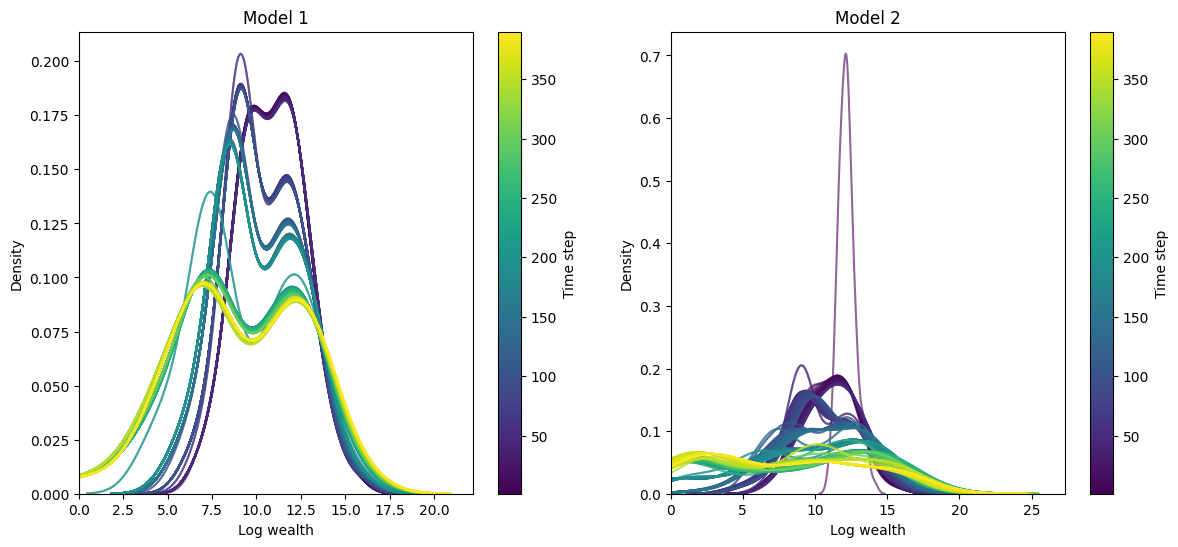

In [5]:

# import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# build average of all ensemble members
result_df['average_wealth'] = result_df.iloc[:, 1:-1].mean(axis=1)
result_df_avg = result_df[['time_step', 'average_wealth']]

# log transform the average data
result_df_avg['log_wealth'] = np.log(result_df_avg['average_wealth'])

# loop over time steps and plot all data as kernel density estimates with a colormap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=1, vmax=390)

for time_step in range(1, 390):
    color = cmap(norm(time_step))
    sns.kdeplot(result_df_avg[result_df_avg['time_step'] == time_step]['log_wealth'], ax=ax1, color=color, label=f'Time step {time_step}', alpha=0.6)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label('Time step')
ax1.set_xlabel('Log wealth')
ax1.set_ylabel('Density')
# set left x axis limit at 0
ax1.set_xlim(left=0)
ax1.set_title('Model 1')


## Model 2
# build average of all ensemble members
result_df_model2['average_wealth'] = result_df_model2.iloc[:, 1:-1].mean(axis=1)
result_df_avg_model2 = result_df_model2[['time_step', 'average_wealth']]
# log transform the average data
result_df_avg_model2['log_wealth'] = np.log(result_df_avg_model2['average_wealth'])

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=1, vmax=390)
for time_step in range(1, 390):
    color = cmap(norm(time_step))
    sns.kdeplot(result_df_avg_model2[result_df_avg_model2['time_step'] == time_step]['log_wealth'], ax=ax2, color=color, label=f'Time step {time_step}', alpha=0.6)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2)
cbar.set_label('Time step')
ax2.set_xlabel('Log wealth')
ax2.set_ylabel('Density')
# set left x axis limit at 0
ax2.set_xlim(left=0)
ax2.set_title('Model 2')

## Plot first update state average across ensemble members vs. observations as well

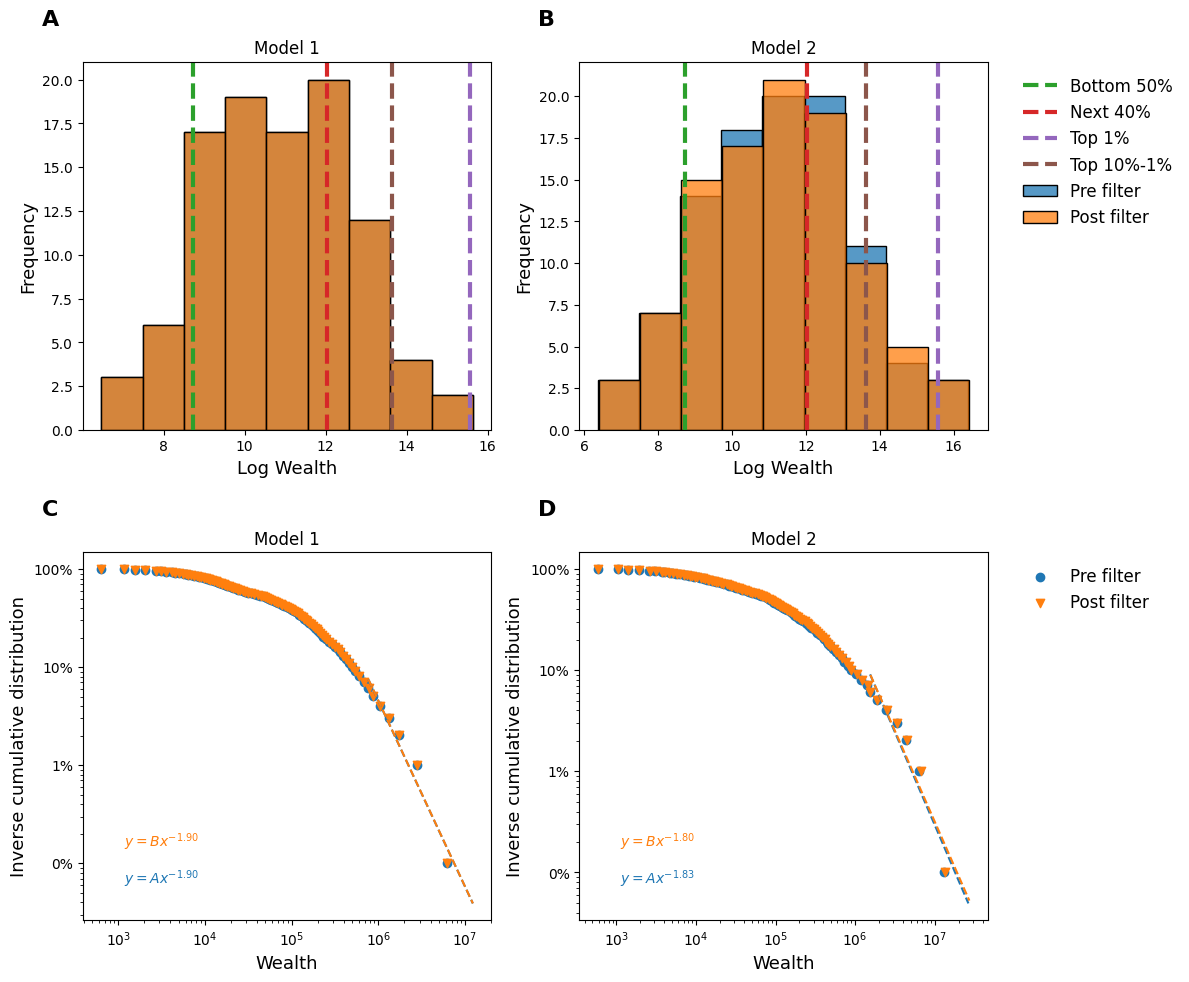

In [6]:
# Load the empirical data
path = '..'
with open(os.path.join(path, 'data', 'wealth_data_for_import.csv')) as f:
    wealth_data = pd.read_csv(f, encoding='unicode_escape')


# Plot time step 20 and 40 kernel density estimates of the log values
# Plot kernel density estimates and empirical data in a 2x2 grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# First model KDE plots
sns.histplot(result_df_avg[result_df_avg['time_step'] == 30]['log_wealth'], ax=ax1, label='Time step 31: Pre filter', color='tab:blue')
sns.histplot(result_df_avg[result_df_avg['time_step'] == 31]['log_wealth'], ax=ax1, label='Time step 32: Post filter', color='tab:orange')

# Subset the data to the years 1990-2022
wealth_data = wealth_data[(wealth_data['year'] >= 1990) & (wealth_data['year'] <= 2022)]
# Subset wealth data based on column year being 1992 and month column being 7
wealth_data_empirical = wealth_data[(wealth_data['year'] == 1992) & (wealth_data['month'] == 7)]
# Subset the column real_wealth_per_unit only and log transform the data
wealth_data_empirical_log = np.log(wealth_data_empirical['real_wealth_per_unit'])

# Plot vertical lines for the empirical data
empirical_labels = ['Bottom 50%', 'Next 40%', 'Top 1%', 'Top 10%-1%']
empirical_colors = ['tab:green', 'tab:red', 'tab:purple', 'tab:brown']
for i, (value, label, color) in enumerate(zip(wealth_data_empirical_log, empirical_labels, empirical_colors)):
    ax1.axvline(value, color=color, linestyle='--', linewidth=3, label=label)
    ax2.axvline(value, color=color, linestyle='--', linewidth=3, label=label)

# Second model KDE plots
sns.histplot(result_df_avg_model2[result_df_avg_model2['time_step'] == 30]['log_wealth'], ax=ax2, label='Pre filter', color='tab:blue')
sns.histplot(result_df_avg_model2[result_df_avg_model2['time_step'] == 31]['log_wealth'], ax=ax2, label='Post filter', color='tab:orange')

# Adjust layout to fit legends outside the plots
fig.tight_layout(rect=[0, 0, 0.85, 1])

fontsize_axislabels = 13

# Place the legend outside the second subplot
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 12, frameon=False)

# Set titles and labels
ax1.set_title('Model 1')
ax1.set_xlabel('Log Wealth', fontsize=fontsize_axislabels)
ax1.set_ylabel('Frequency', fontsize=fontsize_axislabels)

ax2.set_title('Model 2')
ax2.set_xlabel('Log Wealth', fontsize=fontsize_axislabels)
ax2.set_ylabel('Frequency', fontsize=fontsize_axislabels)

ax3.set_title('Model 1')
ax4.set_title('Model 2')

# Plot the non log wealth as inverse cumulative distribution
values_model1_pre_update = np.sort(result_df_avg[result_df_avg['time_step'] == 30]['average_wealth'])
values_model1_post_update = np.sort(result_df_avg[result_df_avg['time_step'] == 31]['average_wealth'])
# make cumulative percentiles of values
percentiles = np.linspace(0, 100, len(values_model1_pre_update))/100
# plot the percentiles
inv_cumulative = 1-percentiles
# last value add tiny positive value to avoid log(0)
inv_cumulative[-1] = inv_cumulative[-1] + 1e-3
# plot the percentiles
ax3.scatter(values_model1_pre_update, inv_cumulative, label='Pre filter', color='tab:blue')
ax3.scatter(values_model1_post_update, inv_cumulative, label='Post filter', color='tab:orange', marker = "v")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('Wealth', fontsize=fontsize_axislabels)
ax3.set_ylabel('Inverse cumulative distribution', fontsize=fontsize_axislabels)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))



# Plot the non log wealth as inverse cumulative distribution
values_model2_pre_update = np.sort(result_df_avg_model2[result_df_avg_model2['time_step'] == 30]['average_wealth'])
values_model2_post_update = np.sort(result_df_avg_model2[result_df_avg_model2['time_step'] == 31]['average_wealth'])
# make cumulative percentiles of values
percentiles = np.linspace(0, 100, len(values_model2_pre_update))/100

ax4.scatter(values_model2_pre_update, inv_cumulative, label='Pre filter', color='tab:blue')
ax4.scatter(values_model2_post_update, inv_cumulative, label='Post filter', color='tab:orange', marker = "v")
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_xlabel('Wealth', fontsize=fontsize_axislabels)
ax4.set_ylabel('Inverse cumulative distribution', fontsize=fontsize_axislabels)
ax4.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, frameon=False)


# Label the panels
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, size=16, weight='bold')
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, size=16, weight='bold')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, size=16, weight='bold')
ax4.text(-0.1, 1.1, 'D', transform=ax4.transAxes, size=16, weight='bold')




# make the power law fits for panel 1 and panel 2 
last7 = values_model1_pre_update[-7:]
# last 7 percentiles
inv_cumulative_last7 = inv_cumulative[-7:]
# make linear fit of last7 as x and percentiles_last7 as y
slope0, intercept0 = np.polyfit(np.log(last7), np.log(inv_cumulative_last7), 1)
# make power law fit with the slope and intercept
# Create dummy data using the min of last7 and max of last7 times 2
x_dummy = np.linspace(min(last7), max(last7) * 2, 100)
power_law = np.exp(slope0*np.log(x_dummy) + intercept0)
ax3.plot(x_dummy, power_law, label='Power law fit', color='tab:blue', linestyle='--')
# plot equation lower left corner of ax3
ax3.text(0.1, 0.1, f'$y = Ax^{{{slope0:.2f}}}$', transform=ax3.transAxes, color='tab:blue')


# do fit for the  values_model1_post_update
last7 = values_model1_post_update[-7:]
# last 7 percentiles
inv_cumulative_last7 = inv_cumulative[-7:]
# make linear fit of last7 as x and percentiles_last7 as y
slope1, intercept1 = np.polyfit(np.log(last7), np.log(inv_cumulative_last7), 1)
# make power law fit with the slope and intercept
x_dummy = np.linspace(min(last7), max(last7) * 2, 100)
power_law = np.exp(slope1*np.log(x_dummy) + intercept1)
ax3.plot(x_dummy, power_law, label='Power law fit', color='tab:orange', linestyle='--')
# plot equation lower left corner of ax3
ax3.text(0.1, 0.2, f'$y = Bx^{{{slope1:.2f}}}$', transform=ax3.transAxes, color='tab:orange')

# do the fit for the model 2 values_model2_pre_update
last7 = values_model2_pre_update[-7:]
# last 7 percentiles
inv_cumulative_last7 = inv_cumulative[-7:]
# make linear fit of last7 as x and percentiles_last7 as y
slope2, intercept2 = np.polyfit(np.log(last7), np.log(inv_cumulative_last7), 1)
# make power law fit with the slope and intercept
x_dummy = np.linspace(min(last7), max(last7) * 2, 100)
power_law = np.exp(slope2*np.log(x_dummy) + intercept2)
ax4.plot(x_dummy, power_law, label='Power law fit', color='tab:blue', linestyle='--')
# plot equation lower left corner of ax3
ax4.text(0.1, 0.1, f'$y = Ax^{{{slope2:.2f}}}$', transform=ax4.transAxes, color='tab:blue')


# do fit for the  values_model2_post_update
last7 = values_model2_post_update[-7:]
# last 7 percentiles
inv_cumulative_last7 = inv_cumulative[-7:]
# make linear fit of last7 as x and percentiles_last7 as y
slope3, intercept3 = np.polyfit(np.log(last7), np.log(inv_cumulative_last7), 1)
# make power law fit with the slope and intercept
x_dummy = np.linspace(min(last7), max(last7) * 2, 100)
power_law = np.exp(slope3*np.log(x_dummy) + intercept3)
ax4.plot(x_dummy, power_law, label='Power law fit', color='tab:orange', linestyle='--')
# plot equation lower left corner of ax4
ax4.text(0.1, 0.2, f'$y = Bx^{{{slope3:.2f}}}$', transform=ax4.transAxes, color='tab:orange')

plt.tight_layout()

plt.savefig('fig5.png', dpi=300)

